In [1]:
# Import basic libraries and tools
import os
import warnings
from time import time
from scipy.special import gamma
import math
from sympy import Rational, trigsimp, simplify, expand, factor, Abs, sign, latex, sin, cos, diff, Order
from functions.sympy_help import *
from functions.inclination_funcs import F_func
from functions.eccentricity_funcs import G_func
from functions.general_math import binomial_coeff, besselj_func
from functions.hansen import hansen_wrapper
from functions.hansen import hansen_bessel as hansen_domain_0
from functions.hansen import hansen_kIsZero_nIsNeg as hansen_domain_1
from functions.hansen import hansen_kIsZero_nIsPos as hansen_domain_2

In [2]:
# use real or symbolic legendre polynomials
#legP = legendreP
legP = legendreP_symbolic

# use NSR
use_nsr = True

# Set Max l
min_l = 2
max_l = 2

# Set max power of eccentricity
max_e_power = 6

# Performance Notes:
#    Compiling Results for l=2, e=20 on my desktop takes 68952.3862695694 Sec (19 Hours)
#    After ^ that compile, did it for l=3, e=20 ** ** takes 104769.17482447624 Sec (29 Hours) 
#   ^^ for l=7, e=20 ^^ takes 376306.64565110207 (using function, not this notebook) (4.35 days)

max_e_calc_power = max_e_power

max_q = math.ceil(max_e_calc_power / 2)
max_q += 2
print(max_q)

if max_e_power > 18:
    warnings.warn('Setting the max eccentricity power to above 18 may require significant system memory and (until multi-processing is implemented) significant calculation times.')

5


In [3]:
# Calculate universal coefficients
print_uni_coeffs = False
if print_uni_coeffs:
    for l in range(7, 7+1):
        for m in range(0, l+1):
            if m == 0:
                universal_coeff = Rational(gamma(1 + l - m), gamma(1 + l + m))
            else:
                universal_coeff = 2*Rational(gamma(1 + l - m), gamma(1 + l + m))
            print(l, m)
            disp(universal_coeff)

In [4]:
# Print and/or Save to Disk Inclination Functions

print_inclines = False
reduce_fractions = True
tab = '    '

l_ = max_l

incline_str = '@njit\ndef calc_inclination(inclination: FloatArray) -> Dict[Tuple[int, int], FloatArray]:\n' + tab + '"""Calculate F^2_lmp for l = ' + f'{l_}' + '"""\n\n' + tab
incline_str += f'# Inclination Functions Calculated for l = {l_}.\n' + tab
incline_str_off = '@njit\ndef calc_inclination_off(inclination: FloatArray) -> Dict[Tuple[int, int], FloatArray]:\n' + tab + '"""Calculate F^2_lmp (assuming I=0) for l = ' + f'{l_}' + '"""\n\n' + tab
incline_str_off += f'# Inclination Functions Calculated for l = {l_}, Inclination == off.\n'

incline_str += f'# Optimizations\n' + tab
incline_str += 'i = inclination\n' + tab
incline_str += 'i_half = i / 2.\n' + tab
incline_str += 'i_double = 2. * i\n' + tab
incline_str += 'i_triple = 3. * i\n' + tab
incline_str += 'sin_i = np.sin(i)\n' + tab
incline_str += 'cos_i = np.cos(i)\n' + tab
incline_str += 'sin_i_half = np.sin(i_half)\n' + tab
incline_str += 'cos_i_half = np.cos(i_half)\n' + tab
incline_str += 'sin_i_double = np.sin(i_double)\n' + tab
incline_str += 'cos_i_double = np.cos(i_double)\n' + tab
incline_str += 'sin_i_triple = np.sin(i_triple)\n' + tab
incline_str += 'cos_i_triple = np.cos(i_triple)\n' + '\n'

incline_str += tab + 'inclination_results = {\n'

incline_str_off += tab + 'ones_ = np.ones_like(inclination)\n\n'
incline_str_off += tab + 'inclination_results = {\n'

for m in range(0, l_ + 1):

    for p in range(0, l_ + 1):

        F2 = trigsimp(F_func(l_, m, p, obliquity_sat)**2)
        if print_inclines:
            print(l_, m, p)
            disp(F2)
        F2_off = F2.subs(obliquity_sat, 0)
        if reduce_fractions:
            F2 = F2.evalf(25)
            F2_off = F2_off.evalf(25)
        F2_str = str(F2)
        F2_off_str = str(F2_off)
        F2_str = F2_str.replace('sin(I___S/2)', 'sin_i_half')
        F2_str = F2_str.replace('cos(I___S/2)', 'cos_i_half')
        F2_str = F2_str.replace('sin(2*I___S)', 'sin_i_double')
        F2_str = F2_str.replace('cos(2*I___S)', 'cos_i_double')
        F2_str = F2_str.replace('sin(3*I___S)', 'sin_i_triple')
        F2_str = F2_str.replace('cos(3*I___S)', 'cos_i_triple')
        F2_str = F2_str.replace('sin(I___S)', 'sin_i')
        F2_str = F2_str.replace('cos(I___S)', 'cos_i')

        if F2_str == '0':
            pass
        else:
            incline_str += 2*tab + f'({m}, {p}) : ' + F2_str
            if m == l_ and p == l_:
                incline_str += '\n'
            else:
                incline_str += ',\n'

        if F2_off_str == '0':
            pass
        else:
            incline_str_off += 2*tab + f'({m}, {p}) : ' + F2_off_str + ' * ones_'
            if m == l_ and p == l_:
                incline_str_off += '\n'
            else:
                incline_str_off += ',\n'

incline_str += tab + '}\n'
incline_str += '\n' + tab + 'return inclination_results\n'
incline_str_off += tab + '}\n'
incline_str_off += '\n' + tab + 'return inclination_results\n'

file_name = f'NSR Dissipation - TidalPy Output - Inclination Output for {l_}.py'
with open(file_name, 'w') as incline_file:
    incline_file.write(incline_str_off + '\n\n')
    incline_file.write(incline_str)

In [5]:
## Comparison to Kaula...
compare_to_kaula = False

if compare_to_kaula:
    f_table_kaula = {
        (2, 0, 0): -Rational(3, 8) * (sin(obliquity_sat))**2,
        (2, 0, 1): Rational(3, 4) * (sin(obliquity_sat))**2 - Rational(1, 2),
        (2, 0, 2): -Rational(3, 8) * (sin(obliquity_sat))**2,
        (2, 1, 0): Rational(3, 4) * sin(obliquity_sat)*(1 + cos(obliquity_sat)),
        (2, 1, 1): -Rational(3, 2) * sin(obliquity_sat) * cos(obliquity_sat),
        (2, 1, 2): Rational(3, 4) * sin(obliquity_sat) * (cos(obliquity_sat) - 1),
        (2, 2, 0): Rational(3, 4) * (1 + cos(obliquity_sat))**2,
        (2, 2, 1): Rational(3, 2) * (sin(obliquity_sat))**2,
        (2, 2, 2): Rational(3, 4) * (1 - cos(obliquity_sat))**2,

    }

    for m in range(0, 2+1):
        for p in range(0, 2+1):
            print(2, m, p)
            disp(taylor(trigsimp(f_table_sat[(2, m, p)] / f_table_kaula[(2, m, p)]), obliquity_sat, 2))

In [6]:
# Test what q-values we should include.taylor(func, x, n, x0=0., debug=False)
show_q_check = False
show_all_relavent_qs = False
show_specific_qs = []

if show_q_check:
    if show_all_relavent_qs:
        q_range = range(-max_q, max_q+1)
    else:
        q_range = show_specific_qs

    for q_ in q_range:
        
        print('... next q ...')
        print(f'\tq = {q_}')
        for p_ in [0, 1, 2]:
            print('... next p ...')
            print(f'\tp = {p_}')
            t_i = time()
            _, g_ = G_func(2, p_, q_, eccentricity, cutoff_power=max_e_calc_power)
            print(f'Calc Time = {time() - t_i}')
            
#             print('\tG')
#             disp(g)
            print('\tG^2')
            
            t_i = time()
            if g_.getO() is None:
                res = g_**2
            else:
                g_ = g_.removeO()**2
                res = taylor(g_, eccentricity, max_e_calc_power+1)
            print(f'Taylor Time = {time() - t_i}')
            disp(res)

In [7]:
# Primary Calculation Point: Build eccentricity, obliquity, and mode tables

print_list = False
build_tables = True
loud_eccentricity_funcs = True

g_table = dict()
f_table_host = dict()
f_table_sat = dict()
g2_table = dict()
f2_table_host = dict()
f2_table_sat = dict()
omega_table_host = dict()
omega_table_sat = dict()
freq_table_host = dict()
freq_table_sat = dict()
sign_table_host = dict()
sign_table_sat = dict()
love_table_host = dict()
love_table_sat = dict()
love_omg_table_host = dict()
love_omg_table_sat = dict()

init_time = time()

if print_list or build_tables:
    for l in range(min_l, max_l+1):
        
        try:
            love_func_host = love_func_lookup['host'][l]
            love_func_sat = love_func_lookup['sat'][l]
        except KeyError:
            raise NotImplemented(f'l = {l} has not been implemented.')
        
        for m in range(0, l+1):
            for p in range(0, l+1):
                
                if build_tables:
                    # Build Inclination (Obliquity) Tables
                    f_table_host[(l, m, p)] = F_func(l, m, p, obliquity_host, auto_taylor=False, run_trigsimp=False)
                    f_table_sat[(l, m, p)] = F_func(l, m, p, obliquity_sat, auto_taylor=False, run_trigsimp=False)
                    f2_table_host[(l, m, p)] = simplify(expand(f_table_host[(l, m, p)] * f_table_host[(l, m, p)]))
                    f2_table_sat[(l, m, p)] = simplify(expand(f_table_sat[(l, m, p)] * f_table_sat[(l, m, p)]))
        
                for q in range(-max_q, max_q+1):
                    
                    if build_tables:
                        # Build Eccentricity Tables
                        if m == 0:
                            # There are only unique eccentricity functions for the m=0 (they are the same for other m's)
                            q_init_time = time()
                            if loud_eccentricity_funcs:
                                print(f'Building: ({l}, {m}, {p}, {q})  ')
                            
                            is_exact, g_table[(l, p, q)] = G_func(l, p, q, eccentricity, max_e_calc_power, going_to_square=True)
                            
                            if is_exact:
                                g2_table[(l, p, q)] = simplify(g_table[(l, p, q)]**2)
                            else:
                                g2_table[(l, p, q)] = taylor(g_table[(l, p, q)].removeO()**2, eccentricity,
                                                             max_e_calc_power+1)
                            
                            if loud_eccentricity_funcs:
                                print(f'\tTime to Build Mode: {time() - q_init_time:0.2f} s')
                    
                    # Build Mode and Frequency Tables
                    omega_table_host[(l, m, p, q)] = (l - 2*p + q)*mean_n - m*spin_host
                    omega_table_sat[(l, m, p, q)] = (l - 2*p + q)*mean_n - m*spin_sat
                    freq_table_host[(l, m, p, q)] = Abs(omega_table_host[(l, m, p, q)])
                    freq_table_sat[(l, m, p, q)] = Abs(omega_table_sat[(l, m, p, q)])
                    sign_table_host[(l, m, p, q)] = sign(omega_table_host[(l, m, p, q)])
                    sign_table_sat[(l, m, p, q)] = sign(omega_table_sat[(l, m, p, q)])
                    
                    # Build Love Number Tables
                    if omega_table_host[(l, m, p, q)] == 0.:
                        love_table_host[(l, m, p, q)] = 0.
                        love_omg_table_host[(l, m, p, q)] = 0.
                    else:
                        love_table_host[(l, m, p, q)] = love_func_host(freq_table_host[(l, m, p, q)])
                        love_omg_table_host[(l, m, p, q)] = love_func_host(omega_table_host[(l, m, p, q)])
                    if omega_table_sat[(l, m, p, q)] == 0.:
                        love_table_sat[(l, m, p, q)] = 0.
                        love_omg_table_sat[(l, m, p, q)] = 0.
                    else:
                        love_table_sat[(l, m, p, q)] = love_func_sat(freq_table_sat[(l, m, p, q)])
                        love_omg_table_sat[(l, m, p, q)] = love_func_sat(omega_table_sat[(l, m, p, q)])
                    
                    if print_list:
                        disp('')
                        print(f'\nl, m, p, q = {l}{m}{p}{q}')
                        print('\tMode_h=')
                        disp(nsimplify(omega_table_host[(l, m, p, q)]))
                        print('\tG(e)=')
                        disp(nsimplify(g_table[(l, p, q)]))
                        print('\tF_h(I)=')
                        disp(nsimplify(f_table_host[(l, m, p)]))

delta_time = time() - init_time
if delta_time >=300:
    time_txt = f'{delta_time/60:0.4f} Mins'
elif delta_time >= 7200:
    time_txt = f'{delta_time/(60*60):0.4f} Hours'
elif delta_time >= 86400:
    time_txt = f'{delta_time/(60*60*24):0.4f} Days'
else:
    time_txt = f'{delta_time:0.2f} Secs'
print(f'Total Time to Construct Tables: {time_txt}')

Building: (2, 0, 0, -5)  
Starting Hansen Calculation (Bessel Domain, CO=3)
0
0[                              ]
0[########                      ]
0[###############               ]
0[#######################       ]
	[##############################]
	Time to Build Mode: 0.13 s
Building: (2, 0, 0, -4)  
Starting Hansen Calculation (Bessel Domain, CO=3)
0
0[                              ]
0[########                      ]
0[###############               ]
0[#######################       ]
	[##############################]
	Time to Build Mode: 0.01 s
Building: (2, 0, 0, -3)  
Starting Hansen Calculation (Bessel Domain, CO=4)
e**3/48
-e**4*(-e**3/8 - e/2)/96 + e**3/48
e**3/48 + O(e**4)               ]
e**3/48 + O(e**4)               ]
e**3/48 + O(e**4)###            ]
e**3/48 + O(e**4)#########      ]
	[##############################]
	Time to Build Mode: 0.18 s
Building: (2, 0, 0, -2)  
	Time to Build Mode: 0.00 s
Building: (2, 0, 0, -1)  
Starting Hansen Calculation (Bessel Domain, CO=6)
-

In [8]:
from pprint import pprint
import copy

gtemp_table = copy.deepcopy(g_table)

for key, dat in g_table.items():
    try:
        gtemp_table[key] = dat.removeO()
    except:
        continue


pprint(gtemp_table)

{(2, 0, -5): 0,
 (2, 0, -4): 0,
 (2, 0, -3): e**3/48,
 (2, 0, -2): 0,
 (2, 0, -1): -5*e**5/384 + e**3/16 - e/2,
 (2, 0, 0): -35*e**6/288 + 13*e**4/16 - 5*e**2/2 + 1,
 (2, 0, 1): 489*e**5/128 - 123*e**3/16 + 7*e/2,
 (2, 0, 2): -115*e**4/6 + 17*e**2/2,
 (2, 0, 3): 845*e**3/48,
 (2, 0, 4): 0,
 (2, 0, 5): 0,
 (2, 1, -5): 0,
 (2, 1, -4): 0,
 (2, 1, -3): 53*e**3/16,
 (2, 1, -2): 7*e**4/4 + 9*e**2/4,
 (2, 1, -1): 261*e**5/128 + 27*e**3/16 + 3*e/2,
 (2, 1, 0): (1 - e**2)**(-3/2),
 (2, 1, 1): 261*e**5/128 + 27*e**3/16 + 3*e/2,
 (2, 1, 2): 7*e**4/4 + 9*e**2/4,
 (2, 1, 3): 53*e**3/16,
 (2, 1, 4): 0,
 (2, 1, 5): 0,
 (2, 2, -5): 0,
 (2, 2, -4): 0,
 (2, 2, -3): 845*e**3/48,
 (2, 2, -2): -115*e**4/6 + 17*e**2/2,
 (2, 2, -1): 489*e**5/128 - 123*e**3/16 + 7*e/2,
 (2, 2, 0): -35*e**6/288 + 13*e**4/16 - 5*e**2/2 + 1,
 (2, 2, 1): -5*e**5/384 + e**3/16 - e/2,
 (2, 2, 2): 0,
 (2, 2, 3): e**3/48,
 (2, 2, 4): 0,
 (2, 2, 5): 0}


In [9]:
# Print Python Function Cache Information
print_cache = False
if print_cache:
    
    print('G and F Funcs')
    print('Inclination Function')
    print(F_func.cache_info())
    print('Eccentricity Function')
    print(G_func.cache_info())
    
    print('\nEccentricity Func Components\nHansen Wrapper')
    print(hansen_wrapper.cache_info())
    print('Hansen Bessel Domain')
    print(hansen_domain_0.cache_info())
    print('Hansen k=0, n>=0')
    print(hansen_domain_1.cache_info())
    print('Hansen k=0, n<0')
    print(hansen_domain_2.cache_info())
    
    print('\nOther Math Funcs')
    print('Binomial Coefficient')
    print(binomial_coeff.cache_info())
    print('Bessel Function')
    print(besselj_func.cache_info())

## Tidal Potential Derivative Calculations

In [9]:
physical_coeffs_sat = dict()
physical_coeffs_host = dict()
eccen_inclin_coeffs_sat = dict()
love_coeffs_sat = dict()
eccen_inclin_coeffs_host = dict()
love_coeffs_host = dict()
universal_coeffs = dict()
dUdM_coeffs = dict()
dUdw_coeffs = dict()
dUdO_coeffs = dict()
full_potential_coeffs = dict()
potential_coeffs = dict()
varpis = list()
longi_mode_dict = dict()

for l in range(min_l, max_l+1):
    for m in range(0, l+1):
        for p in range(0, l+1):
            F_S1 = f_table_sat[(l, m, p)]
            F_H2 = f2_table_host[(l, m, p)]
            F_S2 = f2_table_sat[(l, m, p)]
            
            for q in range(-max_q, max_q+1):
                
                sgn_H = sign_table_host[(l, m, p, q)]
                sgn_S = sign_table_sat[(l, m, p, q)]
                freq_H = freq_table_host[(l, m, p, q)]
                freq_S = freq_table_sat[(l, m, p, q)]
                omg_H = omega_table_host[(l, m, p, q)]
                omg_S = omega_table_sat[(l, m, p, q)]
                love_H = love_table_host[(l, m, p, q)]
                love_S = love_table_sat[(l, m, p, q)]
                love_omg_H = love_omg_table_host[(l, m, p, q)]
                love_omg_S = love_omg_table_sat[(l, m, p, q)]
                
                G2 = g2_table[(l, p, q)]
                G_ = g_table[(l, p, q)]
                
                eccen_inclin_coeffs_host[(l, m, p, q)] = factor(expand(G2 * F_H2).removeO())
                eccen_inclin_coeffs_sat[(l, m, p, q)] = factor(expand(G2 * F_S2).removeO())
                
                love_coeffs_sat[(l, m, p, q)] = love_S * sgn_S
                love_coeffs_host[(l, m, p, q)] = love_H * sgn_H
                
                dUdM_coeffs[(l, m, p, q)] = l - 2*p + q
                dUdw_coeffs[(l, m, p, q)] = l - 2*p
                dUdO_coeffs[(l, m, p, q)] = m
                
                if m == 0:
                    lm_coeff = Rational(gamma(1 + l - m), gamma(1 + l + m))
                else:
                    lm_coeff = 2 * Rational(gamma(1 + l - m), gamma(1 + l + m))
                    
                universal_coeffs[(l, m, p, q)] = lm_coeff
                
                # The overall negative on the potential is author dependent. Leaving it off for now.
                potential_coeffs[(l, m, p, q)] = \
                    (newton_G * mass_host / semi_major_axis) * lm_coeff * (r_sat / semi_major_axis)**(l) * legP(l, m, cos(latitude)) * factor(expand(G_ * F_S1).removeO())
                varpi = find_varpi(l, m, p, q)
                longi_mode = varpi - m * (longitude + sidereal_time)
                if varpi not in varpis:
                    varpis.append(varpi)
                if (l-m) % 2 == 0:
                    potential_coeffs[(l, m, p, q)] *= cos(longi_mode)
                    longi_mode_dict[(l, m, p, q)] = cos(longi_mode) * legP(l, m, cos(latitude))
                else:
                    potential_coeffs[(l, m, p, q)] *= sin(longi_mode)
                    longi_mode_dict[(l, m, p, q)] = sin(longi_mode) * legP(l, m, cos(latitude))
                    
                full_potential_coeffs[(l, m, p, q)] = 1
                
                # For the purposes of putting coefficients into TidalPy, I want every thing reduced by a factor of 
                #    (3 / 2) as that will be multipled by tidal susceptibility in a later step. 
                universal_coeffs[(l, m, p, q)] /= Rational(3, 2)
                
                physical_coeffs_host[(l, m, p, q)] = \
                    ((radius_host / semi_major_axis)**(2*l + 1) * newton_G * mass_sat) / semi_major_axis
                physical_coeffs_sat[(l, m, p, q)] = \
                    ((radius_sat / semi_major_axis)**(2*l + 1) * newton_G * mass_host) / semi_major_axis
                
print('Completed Coeff Tables Calculations')

Completed Coeff Tables Calculations


## Print and save unique modes

In [31]:
save_mode_data = True
use_obliquity = True
use_nsr = False

if save_mode_data:
    
    needed_lpq = []
    needed_lmp = []
    unique_modes = {}
    for l in range(min_l, min_l+1):
        for m in range(0, l+1):
            for p in range(0, l+1):
                for q in range(-max_q, max_q+1):
                    
                    F_S1 = f_table_sat[(l, m, p)]
                    if not use_obliquity:
                        F_S1 = simplify(F_S1.subs(obliquity_sat, 0))
                        
                    G = g_table[(l, p, q)]
                    try:
                        G = G.removeO()
                    except AttributeError:
                        pass
                        
                    omg_S = omega_table_sat[(l, m, p, q)]                
                    if not use_nsr:
                        omg_S = omg_S.subs(spin_sat, mean_n)
                    
                    if F_S1 != 0. and G != 0. and omg_S != 0.:
                        if omg_S in unique_modes:
                            unique_modes[omg_S] += [(l, m, p, q)]
                        else:
                            unique_modes[omg_S] = [(l, m, p, q)]
                        
                        if (l, p, q) not in needed_lpq:
                            needed_lpq.append((l, p, q))
                        if (l, m, p) not in needed_lmp:
                            needed_lmp.append((l, m, p))
                            
    with open(f'TidalModes_l={min_l}_maxq={max_q}_obli={use_obliquity}_nsr={use_nsr}.py', 'w') as output_file:
        
        for unique_mode, signatures in unique_modes.items():
            mode_str = str(unique_mode).replace('Omega___S', 'spin_frequency').replace('n', 'orbital_frequency')
            num_sigs = len(signatures)
            
        
    

{-7*n: [(2, 2, 2, -3)],
 -6*n: [(2, 1, 2, -3), (2, 2, 2, -2)],
 -5*n: [(2, 0, 2, -3), (2, 1, 2, -2), (2, 2, 1, -3), (2, 2, 2, -1)],
 -4*n: [(2, 0, 2, -2),
        (2, 1, 1, -3),
        (2, 1, 2, -1),
        (2, 2, 1, -2),
        (2, 2, 2, 0)],
 -3*n: [(2, 0, 1, -3),
        (2, 0, 2, -1),
        (2, 1, 1, -2),
        (2, 1, 2, 0),
        (2, 2, 0, -3),
        (2, 2, 1, -1),
        (2, 2, 2, 1)],
 -2*n: [(2, 0, 1, -2),
        (2, 0, 2, 0),
        (2, 1, 0, -3),
        (2, 1, 1, -1),
        (2, 1, 2, 1),
        (2, 2, 1, 0)],
 -n: [(2, 0, 0, -3),
      (2, 0, 1, -1),
      (2, 0, 2, 1),
      (2, 1, 1, 0),
      (2, 2, 0, -1),
      (2, 2, 1, 1),
      (2, 2, 2, 3)],
 n: [(2, 0, 0, -1),
     (2, 0, 1, 1),
     (2, 0, 2, 3),
     (2, 1, 0, 0),
     (2, 1, 1, 2),
     (2, 2, 0, 1),
     (2, 2, 1, 3)],
 2*n: [(2, 0, 0, 0), (2, 0, 1, 2), (2, 1, 0, 1), (2, 1, 1, 3), (2, 2, 0, 2)],
 3*n: [(2, 0, 0, 1), (2, 0, 1, 3), (2, 1, 0, 2), (2, 2, 0, 3)],
 4*n: [(2, 0, 0, 2), (2, 1, 0, 3)],


## Print and save Eccentricity Results

In [12]:
save_tidalpy_data = True
max_e_toconvert_power_sign = 6
reduce_to_floats = False
if save_tidalpy_data:
    
    output_file = f'NSR Dissipation - TidalPy Output - min_order_l {min_l} - max_e {max_e_power}.py'
    
    tab = '    '
    eccentricity_section = '# Unique results.\neccentricity_results_bymode = {\n'
    eccentricity_dupes_section = '\n# Duplicate results are stored as dictionary lookups to previous calculations\n#    Generally leads to a 30--50% speed-up when working with large arrays.\n'
    eccentricity_preamble = f'# Eccentricity functions calculated at truncation level {max_e_power}.\n' +\
                            f'#     and order-l = {min_l}.\n\n'
    needed_eccens = dict()
    eccens_grabbed = list()
    unique_funcs = dict()
    max_e_text_len = 1
    for i in range(2, max_e_power+1, 2):
        needed_eccens[f'e**{i}'] = f'e{i}'
        max_e_text_len = max(max_e_text_len, len(f'e{i}'))
    
    num_eccen = len(g2_table)
    curr_eccen = 0
    
    for l in range(min_l, min_l+1):
        if max_l != min_l:
            raise Exception('TidalPy Printing only designed to work on one "l" at a time.')
            
        for p in range(0, l+1):

            # Make a new p subsection
            eccentricity_section += tab + f'{p}: ' + '{\n'
            
            # Need to include at least one item in each p otherwise njit will not compile correctly
            p_used = False

            for q in range(-max_q, max_q+1):

                gfunc = g2_table[(l, p, q)].removeO()
                if (l, p, q) not in eccens_grabbed:
                    eccens_grabbed.append((l, p, q))

                    # Clean up the equation text
                    if reduce_to_floats:
                        gfunc_clean = str(gfunc.evalf())
                    else:
                        gfunc_clean = str(gfunc)
                    for old_text in list(reversed(sorted(needed_eccens.keys()))):
                            # Get rid of "e**N" in favor of "eN" which are precomputed
                            new_text = needed_eccens[old_text]
                            gfunc_clean = gfunc_clean.replace(old_text, new_text)

                    if gfunc_clean not in unique_funcs or not p_used:
                        
                        if gfunc_clean == '0':
                            # Ignore 0's
                            continue

                        # Unique equation
                        unique_funcs[gfunc_clean] = (l, p, q)


                        # Record the new equation
                        if q < 0:
                            mode_text = f'{q}: '
                        else:
                            mode_text = f'{q}:  '
                        eccentricity_section += 2*tab + mode_text + gfunc_clean
                        if curr_eccen == num_eccen - 1:
                            eccentricity_section += '\n}\n'
                        else:
                            eccentricity_section += ',\n'
                            
                        # Note that at least one thing was added to this p-dict
                        p_used = True
                    else:
                        
                        # If it is a duplicate, simply point to the old equation to save on computation
                        if gfunc_clean == '0':
                            # Ignore 0's
                            continue
                        
                        old_copy_key = unique_funcs[gfunc_clean]
                        old_l, old_p, old_q = old_copy_key
                        eccentricity_dupes_section += f'eccentricity_results_bymode[{p}][{q}] = eccentricity_results_bymode[{old_p}][{old_q}]\n'

                    curr_eccen += 1

            # End the previous p section
            if p == l:
                eccentricity_section += tab + '}\n}'
            else:
                eccentricity_section += tab + '},\n'
                    
                    
    eccentricity_preamble += '# Performance and readability improvements\n'
    eccentricity_preamble += 'e = eccentricity\n'    
    for old_text, new_text in needed_eccens.items():
        for max_e_conversion in range(2, max_e_toconvert_power_sign+2, 2):
            if f'**{max_e_conversion}' == old_text[-3:]:
                old_text = ' * '.join(list('e'*max_e_conversion))
                break
        eccentricity_preamble += f'{new_text}' + ' ' * (max_e_text_len-len(new_text)) + f' = {old_text}\n'
        
    eccentricity_section = eccentricity_preamble + '\n' + eccentricity_section + '\n' + eccentricity_dupes_section
    
    with open(output_file, 'w') as output_file:
        output_file.write(eccentricity_section)

In [12]:
save_latex_table = False
if save_latex_table:
    
    unique_modes = list()
    unique_freqs = list()
    max_eq_length = 100
    
    table_preamble = \
        '\\begin{landscape}\n' + \
        '\\fudge{3cm}{1.5cm} % 3cm longer and raise by 1.5cm\n' + \
        '\\begin{longtable}[c]{@{}c|c|cccc|c|l@{}}\n' + \
        '    \\caption{Caption \\label{tab:dissipation_order10}} \\\\ \\toprule\n' + \
        '    \tMode & Signature & \\multicolumn{4}{c|}{Coefficients, $C_{X}$} & Inclination Function & Eccentricity Function \\\\\n' + \
        '    $\\omega_{j}$ & $l$, $m$, $p$, $q$ & $\\frac{dU_{j}}{d\\mathcal{M}}$ & $\\frac{dU_{j}}{d\\varpi_{j}}$ & $\\frac{dU_{j}}{d\\Omega_{j}}$ & $\\dot{E}_{j}$ & $F^{2}$ & $G^{2}$ \\\\ \\midrule\n' + \
        '    \\midrule           % line head body\n' + \
        '    \\endfirsthead      % Definition of 1. table header\n' + \
        '    \\toprule\n' + \
        '    \\multicolumn{8}{c}{continue table}\\\\\n' + \
        '    Mode & Signature & \\multicolumn{4}{c|}{Coefficients, $C_{X}$} & Inclination Function & Eccentricity Function \\\\\n' + \
        '    $\\omega_{j}$ & $l$, $m$, $p$, $q$ & $\\frac{dU_{j}}{d\\mathcal{M}}$ & $\\frac{dU_{j}}{d\\varpi_{j}}$ & $\\frac{dU_{j}}{d\\Omega_{j}}$ & $\\dot{E}_{j}$ & $F^{2}$ & $G^{2}$ \\\\ \\midrule\n' + \
        '    \\midrule           % line head body\n' + \
        '    \\endhead      % Definition of all following headers\n' + \
        '    \\midrule\n' + \
        '    \\multicolumn{8}{c}{table continues} \\\\ % footer 1. (and more) part(s) of table\n' + \
        '    \\midrule\n' + \
        '    \\endfoot      % foots of the table without the last one\n' + \
        '    \\bottomrule\n' + \
        '    \\endlastfoot  % the last(!!) foot of the table  %%%%%\n' 
    
    table_postamble = \
        '\\end{longtable}\n' + \
        '\\end{landscape}\n'
    
    
    mode_str = ''
    
    for l in range(min_l, max_l+1):
        for m in range(0, l+1):
            for p in range(0, l+1):
                
                this_incline_grabbed = False
                ffunc = f2_table_sat[(l, m, p)]
                ffunc = simplify(ffunc)
                
                for q in range(-max_q, max_q+1):
                    
                    gfunc = g2_table[(l, p, q)].removeO()
                    
                    # Check if G or F funcs are zero. skip if they are
                    if ffunc == 0 or gfunc == 0:
                        continue
                    
                    # If not skipped then we need to add a line. Add the tab
                    mode_str += '\n'  # Line break before new mode.
                    mode_str += f'    % Mode (lmpq) = ({l}, {m}, {p}, {q})\n' # Add a comment for easy searching within the latex
                    mode_str += '    '
                    
                    # Then check if the tidal mode is zero
                    omg_S = omega_table_sat[(l, m, p, q)]
                    if omg_S == 0:
                        continue
                        
                    omg_S_str = str(omg_S).replace('Omega___S', '\\ddot{\\theta}_{j}')
                    omg_S_str = omg_S_str.replace('*', '')
                    mode_str += '$' + omg_S_str + '$'
                    
                    # Store unique modes and freqs
                    if omg_S not in unique_modes:
                        unique_modes.append(omg_S)
                    freq_S = expand(abs(omg_S))
                    if freq_S not in unique_freqs:
                        unique_freqs.append(freq_S)
                    
                    # Next the lmpq
                    if q < 0:
                        mode_str += ' & ' + f'{l}, {m}, {p}, {q}'
                    else:
                        mode_str += ' & ' + f'{l}, {m}, {p}, \;{q}'
                    
                    # Then the coefficients
                    dUdM_coeff = dUdM_coeffs[(l, m, p, q)]
                    dUdw_coeff = dUdw_coeffs[(l, m, p, q)]
                    dUdO_coeff = dUdO_coeffs[(l, m, p, q)]
                    heating_coeff = 1
                    uni_coeff = universal_coeffs[(l, m, p, q)]
                    dUdM_coeff *= uni_coeff
                    dUdw_coeff *= uni_coeff
                    dUdO_coeff *= uni_coeff
                    heating_coeff *= uni_coeff
                    
                    mode_str += ' & $' + latex(dUdM_coeff) + '$ & $' + latex(dUdw_coeff) + '$ & $' + latex(dUdO_coeff) + \
                        '$ & $' + latex(heating_coeff) + '$ & \n'
                    mode_str += '    '
                    
                    # Now the inclination functions
                    if not this_incline_grabbed:
                        
                        # Clean up inclination function string
                        incline_str = latex(ffunc).replace('_{S}', '_{j}')
                        incline_str = incline_str.replace('I^{}', 'I')
                        incline_str = incline_str.replace('\\frac{I_{j}}{2}', 'I_{j}/2')
                        
                        
                        mode_str += '\\begin{math}\n    \\begin{aligned}\n        & '
                        # Check length?
                        mode_str += incline_str
                        mode_str += ' \n    \\end{aligned}\n    \end{math} & \n'
                        this_incline_grabbed = True
                    else:
                        mode_str += '--- & \n'
                    
                    # Finally the eccentricity functions
                    mode_str += '    '
                    eccen_str = latex(gfunc)
                    eccen_str = eccen_str.replace('e^{}', 'e')
                    
                    # Check if the eccentricity function needs to be split onto multiple lines.
                    eccen_lines = 1
                    if len(eccen_str) > max_eq_length:
                        
                        term_list = list()
                        # First split along positives
                        for term in eccen_str.split(' + '):
                            if ' - ' in term:
                                # And then along negatives
                                for t_i, neg_term in enumerate(term.split(' - ')):
                                    if t_i == 0:
                                        # First term is the positive term
                                        term_list.append((neg_term, True))
                                    else:
                                        term_list.append((neg_term, False))
                            else:
                                term_list.append((term, True))
                        
                        # Make new string
                        new_eccen_str = ''
                        running_num = 0
                        for t_i, (term, leading_pos) in enumerate(term_list):
                            if t_i > 0:
                                if leading_pos:
                                    term = ' + ' + term.strip()
                                else:
                                    term = ' - ' + term.strip()
                            else:
                                term = term.strip()
                                    
                            running_num += len(term)
                            if running_num > max_eq_length:
                                new_eccen_str += ' \\\\ \n        &' + term
                                running_num = len(term)
                                eccen_lines += 1
                            else:
                                new_eccen_str += term
                                
                        eccen_str = new_eccen_str
                    
                    # The minipage enviornment allows there to be padding above and below the multi line equations (only thing I could get to work)
                    #    The 80mm probably needs to be adjusted if you give the equations more/less horizontal room.
                    mode_str += '\\begin{minipage}{80mm}\n    \\vspace{2mm}    \\begin{math}\n    \\begin{aligned}\n        & '
                    # Check length?
                    mode_str += eccen_str
                    mode_str += ' \n    \\end{aligned}\n    \\end{math}\n    \\vspace{2mm}\n    \\end{minipage} \\\\ \\hline\n'
                    
    # Save as text file
    with open(f'NSR Dissipation - Latex Output - emax_{max_e_power}_minl_{min_l}.txt', 'w') as latex_file:
        output_str = table_preamble + mode_str + table_postamble
        latex_file.write(output_str)

    print('Done!')
    print('# Unique Modes:', len(unique_modes))
    print('# Unique Frequencies:', len(unique_freqs))

In [13]:
print('Type "c" and press enter to continue the calculations')
breakpoint()

Type "c" and press enter to continue the calculations


### Compile Derivatives

In [10]:
beta = (mass_host * mass_sat) / (mass_host + mass_sat)

# Host
torque_H = 0.
heating_H = 0.
dUdM_H = 0.
dUdw_H = 0.
dUdO_H = 0.
for mode, love_coeff in love_coeffs_host.items():
    ei_coeff = eccen_inclin_coeffs_host[mode]
    uni_coeff = universal_coeffs[mode]
    phys_coeff = physical_coeffs_host[mode]
    dUdM_coeff = dUdM_coeffs[mode]
    dUdw_coeff = dUdw_coeffs[mode]
    dUdO_coeff = dUdO_coeffs[mode]
    freq = freq_table_host[mode]
    sgn_H = sign_table_host[mode]
    love_H = love_table_host[mode]
    
    heating_H += expand(Rational(3, 2) * ei_coeff * uni_coeff * phys_coeff * freq * love_H * mass_sat)
    torque_H += expand(Rational(3, 2) * dUdO_coeff * ei_coeff * uni_coeff * phys_coeff * love_coeff * mass_sat)
    dUdM_H += expand(Rational(3, 2) * dUdM_coeff * ei_coeff * uni_coeff * phys_coeff * love_coeff)
    dUdw_H += expand(Rational(3, 2) * dUdw_coeff * ei_coeff * uni_coeff * phys_coeff * love_coeff)
    dUdO_H += expand(Rational(3, 2) * dUdO_coeff * ei_coeff * uni_coeff * phys_coeff * love_coeff)
    
    
# Satellite
heating_S = 0
torque_S = 0
dUdM_S = 0
dUdw_S = 0
dUdO_S = 0
potential = 0
heating_S_simp = 0
torque_S_simp = 0
dUdM_S_simp = 0
dUdw_S_simp = 0
dUdO_S_simp = 0
for mode, love_coeff in love_coeffs_sat.items():
    ei_coeff = eccen_inclin_coeffs_sat[mode]
    uni_coeff = universal_coeffs[mode]
    phys_coeff = physical_coeffs_sat[mode]
    dUdM_coeff = dUdM_coeffs[mode]
    dUdw_coeff = dUdw_coeffs[mode]
    dUdO_coeff = dUdO_coeffs[mode]
    fullpot_coeff = full_potential_coeffs[mode]
    freq = freq_table_sat[mode]
    sgn_S = sign_table_sat[mode]
    love_S = love_table_sat[mode]
    
    heating_S += expand(Rational(3, 2) * ei_coeff * uni_coeff * phys_coeff * freq * love_S * mass_host)
    torque_S += expand(Rational(3, 2) * dUdO_coeff * ei_coeff * uni_coeff * phys_coeff * love_coeff * mass_host)
    dUdM_S += expand(Rational(3, 2) * dUdM_coeff * ei_coeff * uni_coeff * phys_coeff * love_coeff)
    dUdw_S += expand(Rational(3, 2) * dUdw_coeff * ei_coeff * uni_coeff * phys_coeff * love_coeff)
    potential += expand(potential_coeffs[mode])
    
    heating_S_simp += expand(ei_coeff * uni_coeff * freq * love_S)
    torque_S_simp += expand(dUdO_coeff * ei_coeff * uni_coeff * love_coeff)
    dUdM_S_simp += expand(dUdM_coeff * ei_coeff * uni_coeff * love_coeff)
    dUdw_S_simp += expand(dUdw_coeff * ei_coeff * uni_coeff * love_coeff)
    dUdO_S_simp += expand(dUdO_coeff * ei_coeff * uni_coeff * love_coeff)
    
# Check if the user wanted the objects to both be forced into spin-sync from the get go.
if not use_nsr:
    heating_H = sync_spin(heating_H, host=True, sat=False, max_q=max_q)
    torque_H = sync_spin(torque_H, host=True, sat=False, max_q=max_q)
    dUdM_H = sync_spin(dUdM_H, host=True, sat=False, max_q=max_q)
    dUdw_H = sync_spin(dUdw_H, host=True, sat=False, max_q=max_q)
    dUdO_H = sync_spin(dUdO_H, host=True, sat=False, max_q=max_q)
    
    heating_S = sync_spin(heating_S, host=False, sat=True, max_q=max_q)
    torque_S = sync_spin(torque_S, host=False, sat=True, max_q=max_q)
    dUdM_S = sync_spin(dUdM_S, host=False, sat=True, max_q=max_q)
    dUdw_S = sync_spin(dUdw_S, host=False, sat=True, max_q=max_q)
    dUdO_S = sync_spin(dUdO_S, host=False, sat=True, max_q=max_q)
    

In [11]:
tidal_susceptibility = Rational(3, 2) * newton_G * mass_host**2 * radius_sat**5 / semi_major_axis**6
tidal_susceptibility_reduced = Rational(3, 2) * newton_G * mass_host * radius_sat**2 / semi_major_axis**3
radius_factor = (r_sat / radius_sat)**2

In [15]:
#expr = potential / tidal_susceptibility_reduced
reduced_potential = potential / tidal_susceptibility_reduced
reduced_potential = reduced_potential / radius_factor
# Using Wahr+ substitutions
#   "Angular rate of NSR" = Spin - mean_n
expr = reduced_potential.subs(mean_anon, mean_n*time_var)
expr = expr.subs(sidereal_time, spin_sat*time_var)
expr = expr.subs(periapsis, 0)
expr = expr.subs(node, 0)

reduced_longi_modes = dict()
for mode_signature, longi_mode in longi_mode_dict.items():
    reduced_longi_mode = longi_mode.subs(mean_anon, mean_n*time_var)
    reduced_longi_mode = reduced_longi_mode.subs(sidereal_time, spin_sat*time_var)
    reduced_longi_mode = reduced_longi_mode.subs(periapsis, 0)
    reduced_longi_mode = reduced_longi_mode.subs(node, 0)
    reduced_longi_modes[mode_signature] = reduced_longi_mode

# Inclination Assumption
# expr = expr.subs(obliquity_sat, 0)

# Eccentricity Assumption
expr = taylor(expr, eccentricity, 4).removeO()
expr = expand(expr)

# Cross term assumption
# max_order = 4
# orders = sum( Order(eccentricity**a*obliquity_sat**(max_order-a),eccentricity,obliquity_sat) for a in range(max_order+1) )
# expr = taylor(expr, obliquity_sat, 4).removeO()
# expr = expand(expr+orders).removeO()

# Combine on modes
collected = list()
for mode_sig, mode in reduced_longi_modes.items():
    if mode in collected:
        continue
    collected.append(mode)
    expr = collect(expr, mode)

In [13]:
disp(expr)

In [18]:
# Cross term assumption
max_order = 4
orders = sum( Order(eccentricity**a*obliquity_sat**(max_order-a),eccentricity,obliquity_sat) for a in range(max_order+1) )
expr = taylor(expr, obliquity_sat, 4).removeO()
expr = expand(expr+orders).removeO()

# Combine on modes
collected = list()
for mode_sig, mode in reduced_longi_modes.items():
    if mode in collected:
        continue
    collected.append(mode)
    expr = collect(expr, mode)

disp(expr)

In [19]:
disp(expr.subs(spin_sat, mean_n))

## Inclination = 0

Full Potential


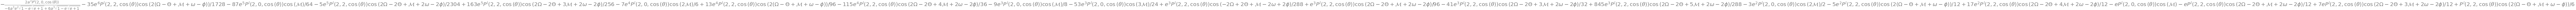

- \frac{2 a^{3} P^{l}{\left(2,0,\cos{\left(\theta \right)} \right)}}{- 6 a^{3} e^{2} \sqrt{1 - e} \sqrt{e + 1} + 6 a^{3} \sqrt{1 - e} \sqrt{e + 1}} - \frac{35 e^{6} P^{l}{\left(2,2,\cos{\left(\theta \right)} \right)} \cos{\left(2 \Omega - 2 \Theta + 2 \mathcal{M} + 2 \omega - 2 \phi \right)}}{1728} - \frac{87 e^{5} P^{l}{\left(2,0,\cos{\left(\theta \right)} \right)} \cos{\left(\mathcal{M} \right)}}{64} - \frac{5 e^{5} P^{l}{\left(2,2,\cos{\left(\theta \right)} \right)} \cos{\left(2 \Omega - 2 \Theta + \mathcal{M} + 2 \omega - 2 \phi \right)}}{2304} + \frac{163 e^{5} P^{l}{\left(2,2,\cos{\left(\theta \right)} \right)} \cos{\left(2 \Omega - 2 \Theta + 3 \mathcal{M} + 2 \omega - 2 \phi \right)}}{256} - \frac{7 e^{4} P^{l}{\left(2,0,\cos{\left(\theta \right)} \right)} \cos{\left(2 \mathcal{M} \right)}}{6} + \frac{13 e^{4} P^{l}{\left(2,2,\cos{\left(\theta \right)} \right)} \cos{\left(2 \Omega - 2 \Theta + 2 \mathcal{M} + 2 \omega - 2 \phi \right)}}{96} - \frac{115 e^{4} P^{l}{\left(2,2,\co

In [16]:
print('Full Potential')
expr = reduced_potential
# expr = taylor(expr, obliquity_sat, 3)
expr = expr.subs(obliquity_sat, 0)
expr = expand(sync_spin(expr, host=True, sat=True, max_q=max_q))
for mode, love_S in love_table_sat.items():
    expr = collect(expr, love_S)
disp(trigsimp(expr))
latex_str = latex(expr)
latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
print(latex_str)

In [ ]:
print('Tidal Heating')
expr=heating_S_simp
expr = taylor(expr, obliquity_sat, 3).removeO()
expr = expand(expr.subs(spin_sat, Rational(3,2) * mean_n))
for mode, love_S in love_table_sat.items():
    expr = collect(expr, love_S)
disp(expr)
latex_str = latex(expr)
latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
print('\nLaTeX:')
print(latex_str)

In [ ]:
print('Tidal Heating')
expr=heating_S_simp
expr = taylor(expr, obliquity_sat, 2)
expr = expand(expr.subs(spin_sat, mean_n))
for mode, love_S in love_table_sat.items():
    expr = collect(expr, love_S)
disp(expr)
latex_str = latex(expr)
latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
print('\nLaTeX:')
print(latex_str)

In [ ]:
# print('dU_dM')
# expr = dUdM_S_simp.subs(inclin_sat, 0)
# expr = expand(sync_spin(expr, host=True, sat=True) / (sign(mean_n)))
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

In [ ]:
# print('dU_dw')
# expr = dUdw_S_simp.subs(inclin_sat, 0)
# expr = expand(sync_spin(expr, host=True, sat=True) / (sign(mean_n)))
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

In [ ]:
# print('dU_dO')
# expr = dUdO_S_simp.subs(inclin_sat, 0)
# expr = expand(sync_spin(expr, host=True, sat=True) / (sign(mean_n)))
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

## Eccentricity = 0

In [ ]:
# print('Full Potential')
# expr = full_potential_simp
# expr = expr.subs(ecc, 0)
# expr = expand(sync_spin(expr, host=True, sat=True))
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

In [ ]:
# print('Tidal Heating')
# expr = heating_S_simp
# expr = expr.subs(ecc, 0)
# expr = expand(sync_spin(expr, host=True, sat=True) / abs(mean_n))
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

In [ ]:
# print('dU_dM')
# expr = dUdM_S_simp.subs(ecc, 0)
# expr = expand(sync_spin(expr, host=True, sat=True) / (sign(mean_n)))
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

In [ ]:
# print('dU_dw')
# expr = dUdw_S_simp.subs(ecc, 0)
# expr = expand(sync_spin(expr, host=True, sat=True) / (sign(mean_n)))
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

In [ ]:
# print('dU_dO')
# expr = dUdO_S_simp.subs(ecc, 0)
# expr = expand(sync_spin(expr, host=True, sat=True) / (sign(mean_n)))
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

## General - Inclin Truncated

In [ ]:
Inclin_trunc = 5

In [ ]:
# print('Full Potential')
# expr = full_potential_simp
# expr = taylor(expr, inclin_sat, Inclin_trunc)
# expr = expand(sync_spin(expr, host=True, sat=True))
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

In [ ]:
print('Tidal Heating')
expr = heating_S_simp
# # expr = taylor(expr, ecc, 12)
expr = expand(sync_spin(expr, host=True, sat=True, max_q=max_q) / (abs(mean_n)))
expr = taylor(expr, obliquity_sat, Inclin_trunc)
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
disp(nsimplify(expr))
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

In [ ]:
# print('dU_dM')
# expr = expand(sync_spin(expr, host=True, sat=True) / (sign(mean_n)))
# expr = taylor(expr, inclin_sat, Inclin_trunc)
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

In [ ]:
# print('dU_dw')
# expr = expand(sync_spin(expr, host=True, sat=True) / (sign(mean_n)))
# expr = taylor(expr, inclin_sat, Inclin_trunc)
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

In [ ]:
# print('dU_dO')
# expr = expand(sync_spin(expr, host=True, sat=True) / (sign(mean_n)))
# expr = taylor(expr, inclin_sat, Inclin_trunc)
# for mode, love_S in love_table_sat.items():
#     expr = collect(expr, love_S)
# disp(expr)
# latex_str = latex(expr)
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
# print(latex_str)

In [ ]:
# Clean up
heating_H = clean_up(heating_H, max_q=max_q)
torque_H = clean_up(torque_H, max_q=max_q)
dUdM_H = clean_up(dUdM_H, max_q=max_q)
dUdw_H = clean_up(dUdw_H, max_q=max_q)
dUdO_H = clean_up(dUdO_H, max_q=max_q)

for mode, love_H in love_table_host.items():
    heating_H = collect(heating_H, love_H)
    dUdM_H = collect(dUdM_H, love_H)
    dUdw_H = collect(dUdw_H, love_H)
    dUdO_H = collect(dUdO_H, love_H)

heating_S = clean_up(heating_S, max_q=max_q)
torque_S = clean_up(torque_S, max_q=max_q)
dUdM_S = clean_up(dUdM_S, max_q=max_q)
dUdw_S = clean_up(dUdw_S, max_q=max_q)
dUdO_S = clean_up(dUdO_S, max_q=max_q)

for mode, love_S in love_table_sat.items():
    heating_S = collect(heating_S, love_S)
    dUdM_S = collect(dUdM_S, love_S)
    dUdw_S = collect(dUdw_S, love_S)
    dUdO_S = collect(dUdO_S, love_S)

## Find Disturbing Potential Derivatives

In [ ]:
dRdM = (1 / beta) * (-mass_host * dUdM_S - mass_sat * dUdM_H)
dRdw_host = (1 / beta) * (-mass_sat * dUdw_H)
dRdw_sat = (1 / beta) * (-mass_host * dUdw_S)
dRdO_host = (1 / beta) * (-mass_sat * dUdO_H)
dRdO_sat = (1 / beta) * (-mass_host * dUdO_S)

In [ ]:
dRdM = expand(clean_up(dRdM.subs(mass_host + mass_sat, mean_n**2 * semi_major_axis**3 / newton_G),
                       max_q=max_q))
dRdw_host = expand(clean_up(dRdw_host.subs(mass_host + mass_sat, mean_n**2 * semi_major_axis**3 / newton_G),
                            max_q=max_q))
dRdw_sat = expand(clean_up(dRdw_sat.subs(mass_host + mass_sat, mean_n**2 * semi_major_axis**3 / newton_G),
                           max_q=max_q))
dRdO_host = expand(clean_up(dRdO_host.subs(mass_host + mass_sat, mean_n**2 * semi_major_axis**3 / newton_G),
                            max_q=max_q))
dRdO_sat = expand(clean_up(dRdO_sat.subs(mass_host + mass_sat, mean_n**2 * semi_major_axis**3 / newton_G),
                           max_q=max_q))

## Find Time Derivatives

In [ ]:
dadt = (2 / (mean_n * semi_major_axis)) * dRdM
dedt = ((1 - eccentricity**2) / (mean_n * semi_major_axis**2 * eccentricity)) * dRdM - \
    ((1 - eccentricity**2)**(Rational(1,2)) / (mean_n * semi_major_axis**2 * eccentricity)) * (dRdw_host + dRdw_sat)
dspin_dt_host = - (beta / moi_host) * dRdO_host
dspin_dt_sat = - (beta / moi_sat) * dRdO_sat

### I = 0, Spin Sync Case

In [ ]:
dadt_synci0 = sync_spin(dadt.subs(obliquity_host, 0).subs(obliquity_sat, 0),
                        sat=True, host=True, max_q=max_q)
dedt_synci0 = sync_spin(dedt.subs(obliquity_host, 0).subs(obliquity_sat, 0),
                        sat=True, host=True, max_q=max_q)
dspin_dt_host_synci0 = sync_spin(dspin_dt_host.subs(obliquity_host, 0).subs(obliquity_sat, 0),
                                 sat=True, host=True, max_q=max_q)
dspin_dt_sat_synci0 = sync_spin(dspin_dt_sat.subs(obliquity_host, 0).subs(obliquity_sat, 0),
                                sat=True, host=True, max_q=max_q)

for mode, love_S in love_table_sat.items():
    dadt_synci0 = collect(dadt_synci0, love_S)
    dedt_synci0 = collect(dedt_synci0, love_S)
    dspin_dt_sat_synci0 = collect(dspin_dt_sat_synci0, love_S)
for mode, love_H in love_table_host.items():
    dadt_synci0 = collect(dadt_synci0, love_H)
    dedt_synci0 = collect(dedt_synci0, love_H)
    dspin_dt_host_synci0 = collect(dspin_dt_host_synci0, love_H)

In [ ]:
print('da/dt')
# disp(dadt_synci0)

latex_str = latex(dadt_synci0/(Rational(3,2)))
# latex_str = latex_str.replace('\\Xi^{}_{S2}', '\\operatorname{K}_{j}')
print(latex_str)

In [ ]:
print('de/dt')
disp(dedt_synci0)

In [ ]:
print('SpinDerivs')
disp(dspin_dt_sat_synci0)
disp(dspin_dt_host_synci0)